# Notebook for Data exploration

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

## DATA FROM KAGGLE

In [47]:
train_data = pd.read_csv("train.csv", delimiter=",")

### Training data size

In [48]:
print("The training data consists of" ,len(train_data),  "instances")

The training data consists of 2400 instances


### Columns in train data

In [49]:
cols = pd.DataFrame(train_data.dtypes)
cols

,0
id,int64
spacegroup,int64
number_of_total_atoms,float64
percent_atom_al,float64
percent_atom_ga,float64
percent_atom_in,float64
lattice_vector_1_ang,float64
lattice_vector_2_ang,float64
lattice_vector_3_ang,float64
lattice_angle_alpha_degree,float64


Given dataset contains 11 attributes. Two attributes - Formation energy and bandgap energy - need to be predicted

### Checking if any of the columns have missing values

In [50]:
train_data.isnull().values.any(axis=0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

The data isn't missing any values, which removes the necessity to remove rows, where part of the data is missing

### Histogram of values from Kaggle

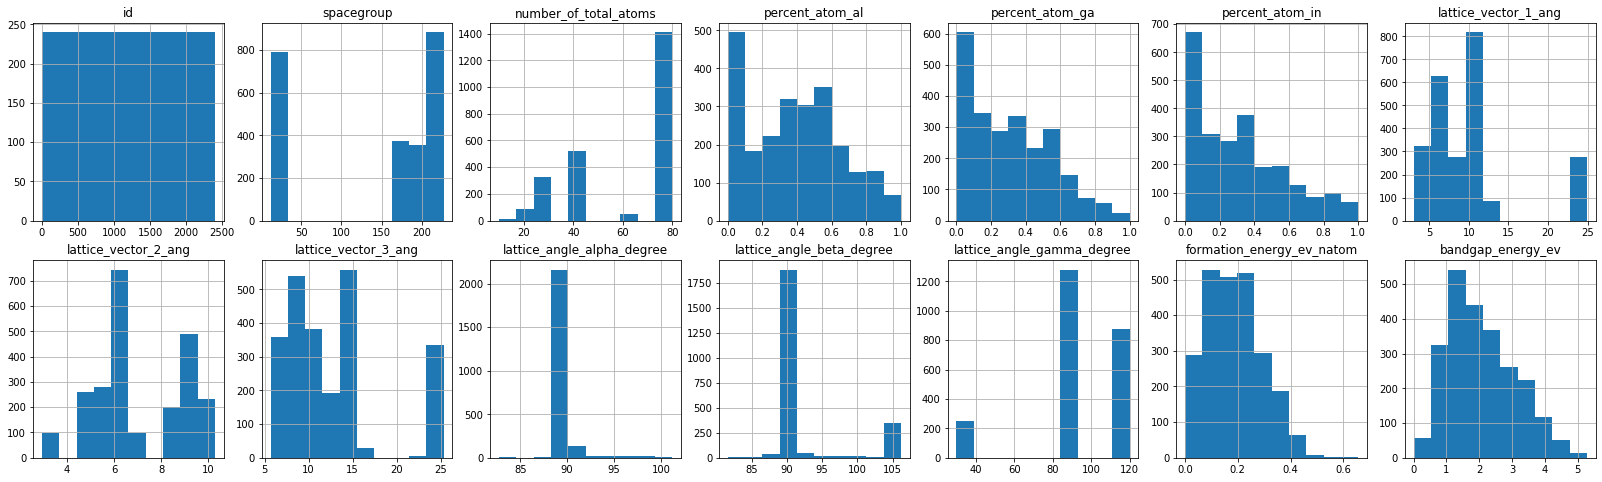

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(28,8))
for col, ax_i in zip(train_data.columns, ax.flatten()):
    train_data[col].hist(ax=ax_i)
    ax_i.set_title(col)
plt.show()

**We can drop id because it contains no useful information for us**

In [52]:
train_data = train_data.drop("id", axis=1)

## Correlations between values from Kaggle

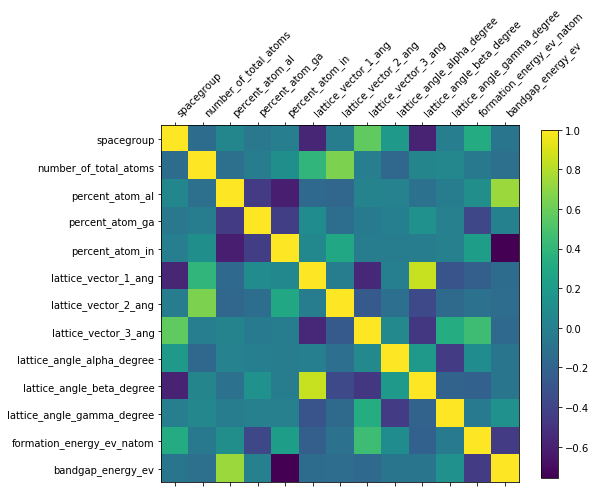

In [53]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(train_data.corr())
ax.set_xticklabels(train_data.columns, rotation = 45, ha="left")
ax.set_yticklabels(train_data.columns)
ax.set_xticks(np.arange(0,13,1))
ax.set_yticks(np.arange(0,13,1))
ax.set_ylim(bottom=12.5, top=-0.5)
fig.colorbar(cax, shrink=0.8)

plt.show()

### The Correlation of Kaggle attributes  with Formation energy

In [57]:
train_data.corr().loc["formation_energy_ev_natom"].drop(["formation_energy_ev_natom", "bandgap_energy_ev"]).sort_values()

percent_atom_ga              -0.374817
lattice_vector_1_ang         -0.225600
lattice_angle_beta_degree    -0.213651
lattice_vector_2_ang         -0.104137
number_of_total_atoms        -0.048631
lattice_angle_gamma_degree   -0.035148
lattice_angle_alpha_degree    0.099277
percent_atom_al               0.108481
percent_atom_in               0.223383
spacegroup                    0.324927
lattice_vector_3_ang          0.454679
Name: formation_energy_ev_natom, dtype: float64

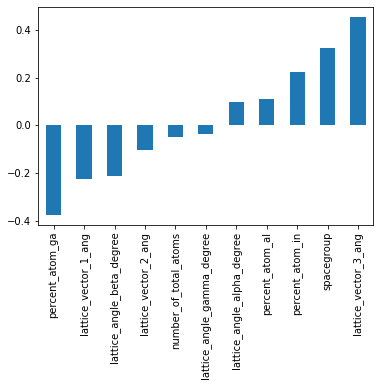

In [58]:
train_data.corr().loc["formation_energy_ev_natom"].drop(["formation_energy_ev_natom", "bandgap_energy_ev"]).sort_values().plot.bar()

### The Correlation of Kaggle attributes  with Bandgap energy

In [59]:
train_data.corr().loc["bandgap_energy_ev"].drop(["formation_energy_ev_natom", "bandgap_energy_ev"]).sort_values()

percent_atom_in              -0.756668
lattice_vector_3_ang         -0.156865
lattice_vector_1_ang         -0.138901
lattice_vector_2_ang         -0.127461
number_of_total_atoms        -0.106125
lattice_angle_beta_degree    -0.077048
spacegroup                   -0.072725
lattice_angle_alpha_degree   -0.072313
percent_atom_ga               0.012831
lattice_angle_gamma_degree    0.133285
percent_atom_al               0.738622
Name: bandgap_energy_ev, dtype: float64

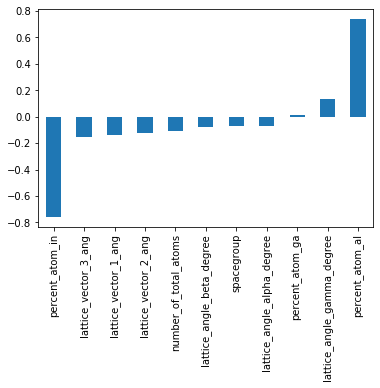

In [60]:
train_data.corr().loc["bandgap_energy_ev"].drop(["formation_energy_ev_natom", "bandgap_energy_ev"]).sort_values().plot.bar()

As we can see from figure above, the correlations between the attributes are mostly not very large. Furthermore, we can see in the correlation matrix that there aren’t many features that are strongly correlated with the target values - formation energy or band gap energy. Most noticeable correlation between target features and attributes are:

* Formation energy - percent_atom_ga
* Formation energy - lattice_vector_3_ang
* Bandgap energy - percent_atom_in
* Bandgap energy - percent_atom_al 

In [38]:
#fig, ax = plt.subplots(nrows=11, ncols=2, figsize=(10,50))
#plt.subplots_adjust(hspace=0.5)
#for col, ax_i in zip(train_data.columns[:-2], ax):
#    ax_i[0].scatter(train_data[col], train_data["formation_energy_ev_natom"])
#    ax_i[1].scatter(train_data[col], train_data["bandgap_energy_ev"])
#    ax_i[0].set_xlabel(col)
#    ax_i[0].set_ylabel("formation_energy_ev_natom")
#    ax_i[1].set_xlabel(col)
#    ax_i[1].set_ylabel("bandgap_energy_ev")
#    ax_i[0].set_title("correlation: " +   str(round(train_data[col].corr(train_data['formation_energy_ev_natom']), 3)))
#    ax_i[1].set_title("correlation: " +  str(round(train_data[col].corr(train_data['bandgap_energy_ev']), 3)))

## CONSTRUCTED FEATURES

As the attributes given by the Kaggle cannot comprehensively describe aforementioned qualities and additional data about so large number of compounds is difficult to collect, we have chosen to calculate other attributes by using the knowledge in theoretical chemistry.

Following features are calculated using the "Data preparation" notebook. The calculation methods are described also there

In [61]:
additional_train_data = pd.read_csv("additionalAttributes.csv", delimiter=",")

### Number of new features

In [62]:
cols = pd.DataFrame(additional_train_data.dtypes)
cols = cols.drop("Unnamed: 0")
cols

,0
Vatom,float64
cAlGa,float64
cAlIn,float64
cAlO,float64
cGaAl,float64
cGaIn,float64
cGaO,float64
cInAl,float64
cInGa,float64
cInO,float64


In [63]:
print("During this work we have constructed" ,len(cols), "new attributes")

During this work we have constructed 25 new attributes


In [64]:
additional_train_data = additional_train_data.drop("Unnamed: 0", axis=1)

### Checking if any of the columns have missing values

In [65]:
for i, t in enumerate(additional_train_data.isnull().values.any(axis=0)):
    if t:
        print(additional_train_data.columns[i])

cInAl
cInGa
cInO
distInAl
distInGa
distInO
qAl
qGa
qIn


These columns have missing values. The missing values are due to the fact that some compounds doesn't contain some elements, which is the fact we have set these values to np.nan. We will approach these missing values and give them certain values, depending on the context in the Model training notebook

### Histogram of created attribute values

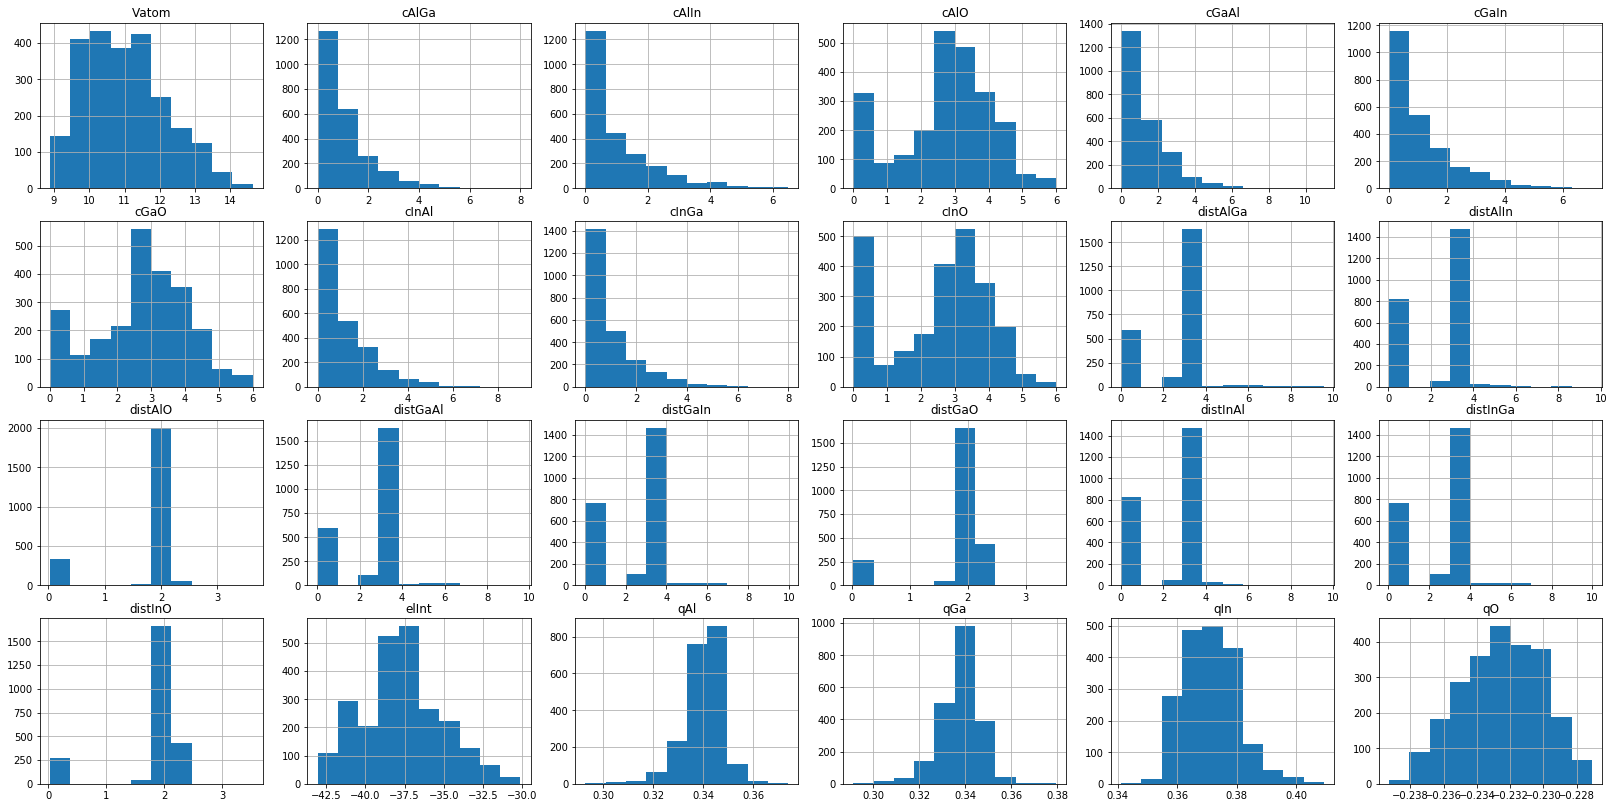

In [66]:
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(28,14))
for col, ax_i in zip(additional_train_data.columns, ax.flatten()):
    additional_train_data[col].hist(ax=ax_i)
    ax_i.set_title(col)
plt.show()

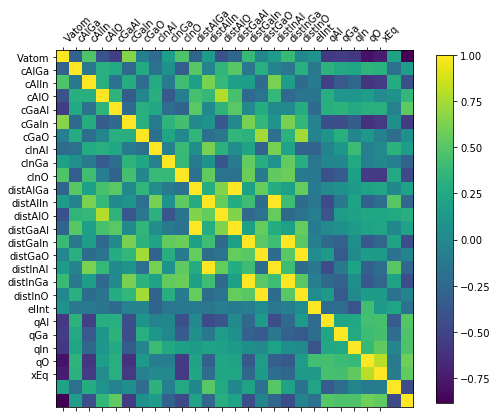

In [67]:
additional_data = pd.concat([additional_train_data, train_data[["formation_energy_ev_natom", "bandgap_energy_ev"]]], axis=1)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(additional_data.corr())
ax.set_xticklabels(additional_data.columns, rotation = 45, ha="left")
ax.set_yticklabels(additional_data.columns)
ax.set_xticks(np.arange(0,25,1))
ax.set_yticks(np.arange(0,25,1))
ax.set_ylim(bottom=26.5, top=-0.5)
fig.colorbar(cax, shrink=0.8)

plt.show()

In [68]:
additional_data.corr().loc["formation_energy_ev_natom"].drop(["formation_energy_ev_natom", "bandgap_energy_ev"]).sort_values()

qAl        -0.345730
cGaO       -0.212919
qGa        -0.206242
cAlGa      -0.187703
distGaO    -0.179550
distInO    -0.179425
qO         -0.103746
xEq        -0.087755
cInGa      -0.072411
cGaAl      -0.055160
qIn        -0.029662
distAlGa   -0.004301
distGaAl   -0.004301
cGaIn       0.051673
cAlO        0.086885
Vatom       0.203634
distInGa    0.204060
distGaIn    0.204589
elInt       0.214056
cInO        0.252451
distAlO     0.260263
cAlIn       0.279537
cInAl       0.334696
distInAl    0.510451
distAlIn    0.510763
Name: formation_energy_ev_natom, dtype: float64

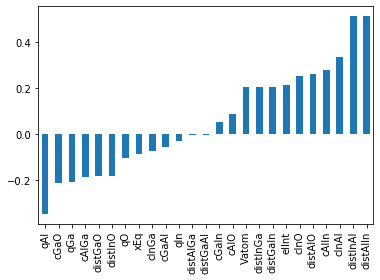

In [69]:
additional_data.corr().loc["formation_energy_ev_natom"].drop(["formation_energy_ev_natom", "bandgap_energy_ev"]).sort_values().plot.bar()

In [70]:
additional_data.corr().loc["bandgap_energy_ev"].drop(["formation_energy_ev_natom", "bandgap_energy_ev"]).sort_values()

Vatom      -0.882862
cGaIn      -0.554871
cInO       -0.466932
distGaIn   -0.430363
distInGa   -0.429916
cAlIn      -0.425078
cInGa      -0.290671
distAlIn   -0.258418
distInAl   -0.257854
elInt      -0.178140
distInO    -0.035327
distGaO    -0.035101
cGaO        0.065699
cInAl       0.151081
cAlGa       0.175096
distAlGa    0.200386
distGaAl    0.200386
distAlO     0.301182
cAlO        0.365964
qGa         0.474771
qIn         0.474874
qAl         0.499917
cGaAl       0.535451
xEq         0.543610
qO          0.583139
Name: bandgap_energy_ev, dtype: float64

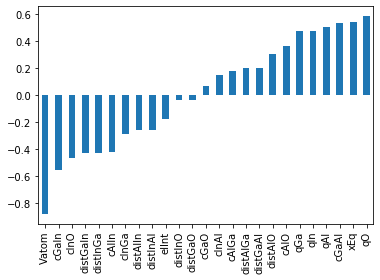

In [71]:
additional_data.corr().loc["bandgap_energy_ev"].drop(["formation_energy_ev_natom", "bandgap_energy_ev"]).sort_values().plot.bar()

As we can see from figure above, the correlations between the attributes are more noticeable than in Attributes given by Kaggle. The distances from X atom to Y (e.g. distGaIn) are almost the same as distance from Y atom to X (e.g. distInGa), as these attributes duplicate the information we drop them in model building.

In the correlation matrix it can be seen, that some new attributes correlate strongly with target attributes:
* Band gap - Vatom
* Band gap - cGaIn
* Band gap - qO


## Preliminary test model

In [21]:
#from sklearn.model_selection import train_test_split
#X = train_data.drop(["formation_energy_ev_natom", "bandgap_energy_ev"], axis=1)
#y_fe = train_data.formation_energy_ev_natom
#y_be = train_data.bandgap_energy_ev
#X_tr, X_te, y_fe_tr, y_fe_te, y_be_tr, y_be_te = train_test_split(X, y_fe, y_be, test_size=0.1)

In [22]:
#from sklearn.metrics import mean_squared_log_error
#def rmsle(y_true, y_pred):
#    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [23]:
#from sklearn.ensemble import RandomForestRegressor
#rfr = RandomForestRegressor(n_estimators=100).fit(X_tr, y_fe_tr)
##  root mean squared logarithmic error is used for evaluation
#print("train error:", rmsle(y_fe_tr, rfr.predict(X_tr)))
#print("test error:", rmsle(y_fe_te, rfr.predict(X_te)) )

In [24]:
#print("feature importances")
#pd.DataFrame([X.columns, rfr.feature_importances_])
